# Spatial binning - Breast cancer

In [1]:
import scanpy as sc
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
sc.set_figure_params(dpi=100)

## Read HD-ST data

In [3]:
adata = sc.read('results/hdst-breast-cancer.h5ad')
adata

AnnData object with n_obs × n_vars = 742440 × 23058 
    obs: 'region', 'segment'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial'

In [4]:
adata.obs['x'] = adata.obsm['X_spatial'][:, 0]
adata.obs['y'] = adata.obsm['X_spatial'][:, 1]

adata.obs.head()

,region,segment,x,y
index,,,,
1000x0,Fibrous tissue;Invasive cancer,0,1000,0
1000x1,Fibrous tissue;Invasive cancer,0,1000,1
1000x10,Fibrous tissue;Invasive cancer,0,1000,10
1000x100,Fibrous tissue;Invasive cancer,0,1000,100
1000x101,Fibrous tissue;Invasive cancer,0,1000,101


... storing 'region' as categorical
... storing 'segment' as categorical


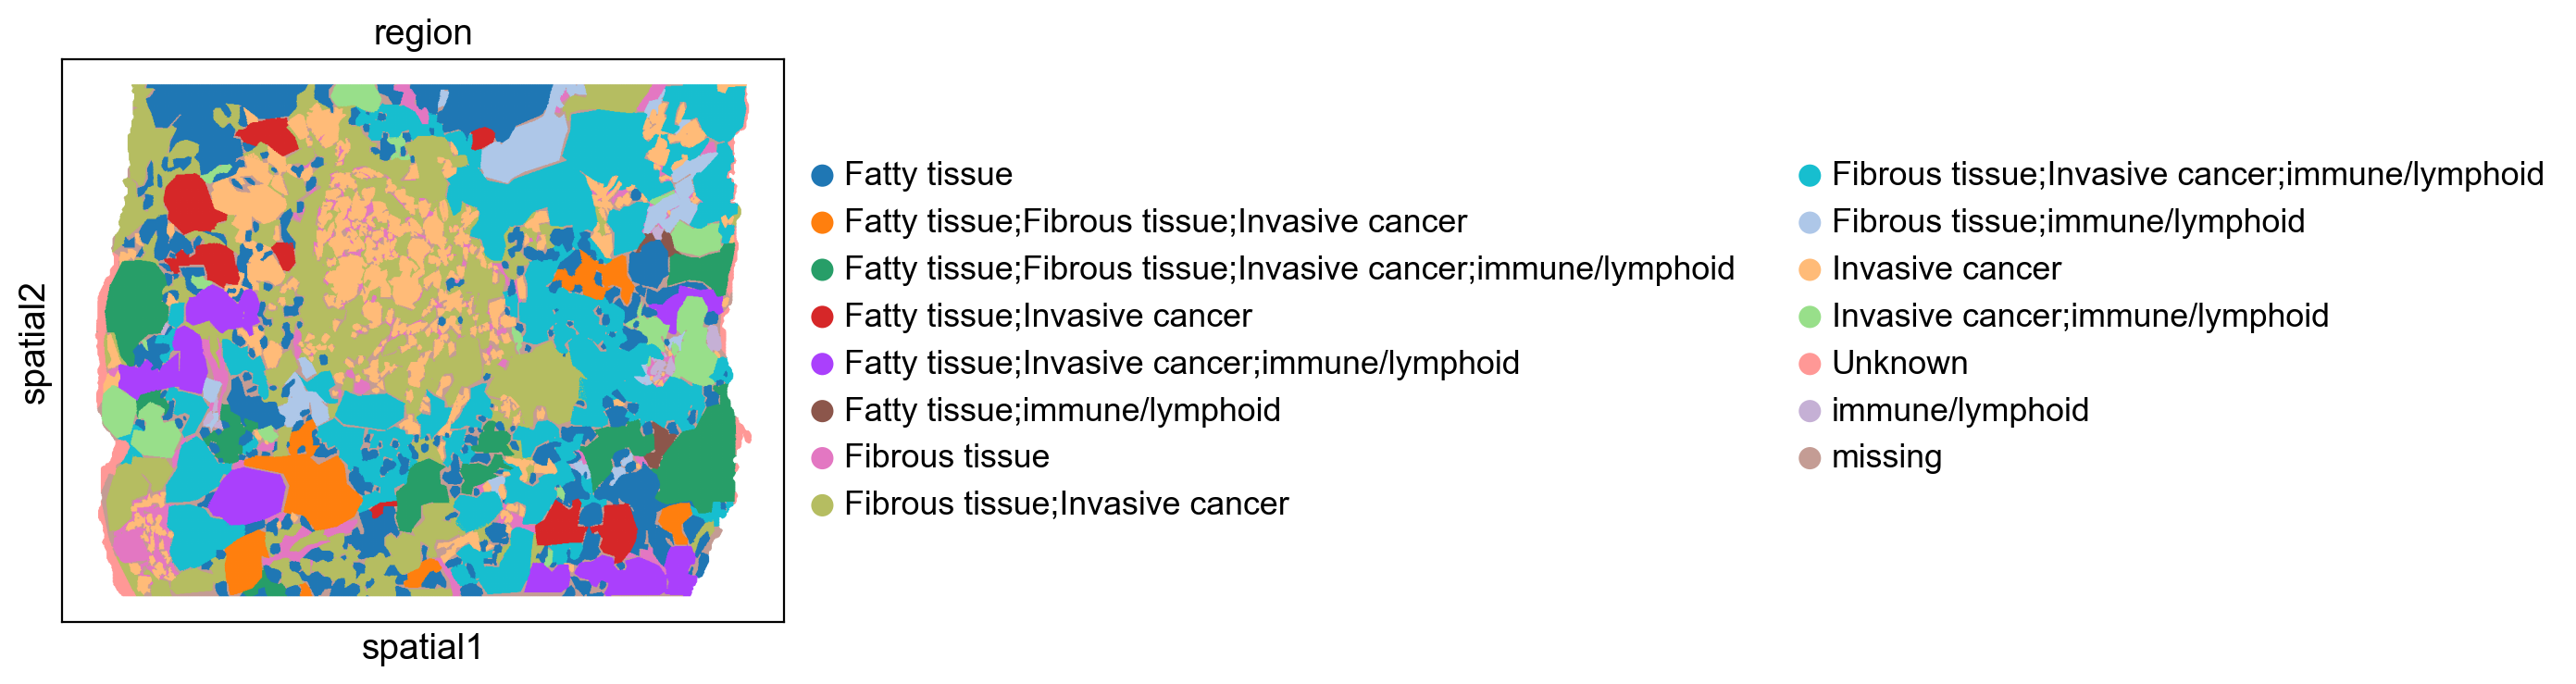

In [5]:
f, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.axis('equal');

sc.pl.scatter(adata, basis='spatial', color='region', size=1., ax=ax, show=False)

# Spatial binning

In [6]:
def matrix2long(x):
    nrow, ncol = x.shape
    xs = np.repeat(np.arange(1, nrow+1), ncol)
    ys = np.tile(np.arange(1, ncol+1), nrow)
    xflat = x.reshape(-1, 1).squeeze()
    
    return xs, ys, xflat

def spatial_bin(x, y, counts, bins, ranges=None, expand_binnumbers=False):
    binres = sp.stats.binned_statistic_2d(x, y, counts, bins=bins, statistic='sum', range=ranges, expand_binnumbers=expand_binnumbers)
    ret = matrix2long(binres.statistic)
        
    return ret, binres.binnumber if expand_binnumbers else None

def spatial_bin_adata(adata, cat_name, binno_colname, bins, ranges=None):
    adata_bin = sc.AnnData(np.zeros((np.prod(bins), adata.n_vars)))
    adata_bin.var_names = adata.var_names
    adata_bin.var = adata.var

    for i, g in enumerate(tqdm_notebook(adata.var_names)):
        (x, y, data), binno = spatial_bin(adata.obs.x, 
                                          adata.obs.y, 
                                          adata[:, g].X, 
                                          bins=bins, 
                                          ranges=ranges,
                                          expand_binnumbers=(i==(adata.n_vars-1)))

        adata_bin[:, g].X = data

    adata_bin.obs['x'] = x
    adata_bin.obs['y'] = y
    adata.obsm[binno_colname] = binno.T

    dfobs = bin_categorical(adata, cat_name, binno[0, :], binno[1, :])

    df = pd.merge(adata_bin.obs, dfobs, how='left', left_on=['x', 'y'], right_on=['bin_x', 'bin_y'], sort=False).reset_index(drop=True)
    df.index = df.index.astype(str)
    df = df.drop(['bin_x', 'bin_y'], axis=1)
    df.fillna(0, inplace=True)

    adata_bin.obs = df
    assert not adata_bin.obs.isnull().values.any()

    return adata_bin

def bin_categorical(adata, cat_name, bin_x, bin_y):
    # make a DF for the .obs
    dfobs = adata.obs.copy()
    dfobs['bin_x'] = bin_x
    dfobs['bin_y'] = bin_y
    
    # group observations based on bins, calculate category frequencies
    dfobs = pd.DataFrame(dfobs.groupby(['bin_x', 'bin_y'], sort=False)[cat_name].value_counts(normalize=True, sort=False)).rename(columns={cat_name: 'freq'})
    dfobs = dfobs.pivot_table(values='freq', columns=cat_name, index=['bin_x', 'bin_y'], fill_value=0)

    dfobs.reset_index(inplace=True)
    dfobs.index = dfobs.index.astype(str)
    dfobs.columns.name = None
    
    return dfobs

### Bead coordinates

In [16]:
bead_coords_x = np.arange(0, adata.obs.x.max()+502)
bead_coords_y = np.arange(0, adata.obs.y.max()+1)

In [17]:
bead_coords_x, bead_coords_y[:10]

(array([   0,    1,    2, ..., 1975, 1976, 1977]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [18]:
bead_coords = np.stack(np.meshgrid(bead_coords_x, bead_coords_y), -1).reshape(-1, 2)
bead_coords_x = bead_coords[:, 0]
bead_coords_y = bead_coords[:, 1]

In [19]:
bead_coords_x, bead_coords_y

(array([   0,    1,    2, ..., 1975, 1976, 1977]),
 array([  0,   0,   0, ..., 782, 782, 782]))

### Lower resolution to make it roughly comparable to standard ST

In [20]:
def calc_bins_and_ranges(factor, xs, ys, factor_mult=0.):
    bins = np.ceil(np.ptp(xs)/factor).astype(int), np.ceil(np.ptp(ys)/factor).astype(int)
    ranges = (-factor*factor_mult, (bins[0]+factor_mult)*factor), (-factor*factor_mult, (bins[1]+factor_mult)*factor)
    return bins, ranges

In [31]:
factor = 5
bins, ranges = calc_bins_and_ranges(factor, bead_coords_x, bead_coords_y)
bins, ranges

((396, 157), ((-0.0, 1980.0), (-0.0, 785.0)))

## Beads per bin (using all beads)

In [32]:
bead_coords_x.shape

(1548774,)

(-0.5, 395.5, 156.5, -0.5)

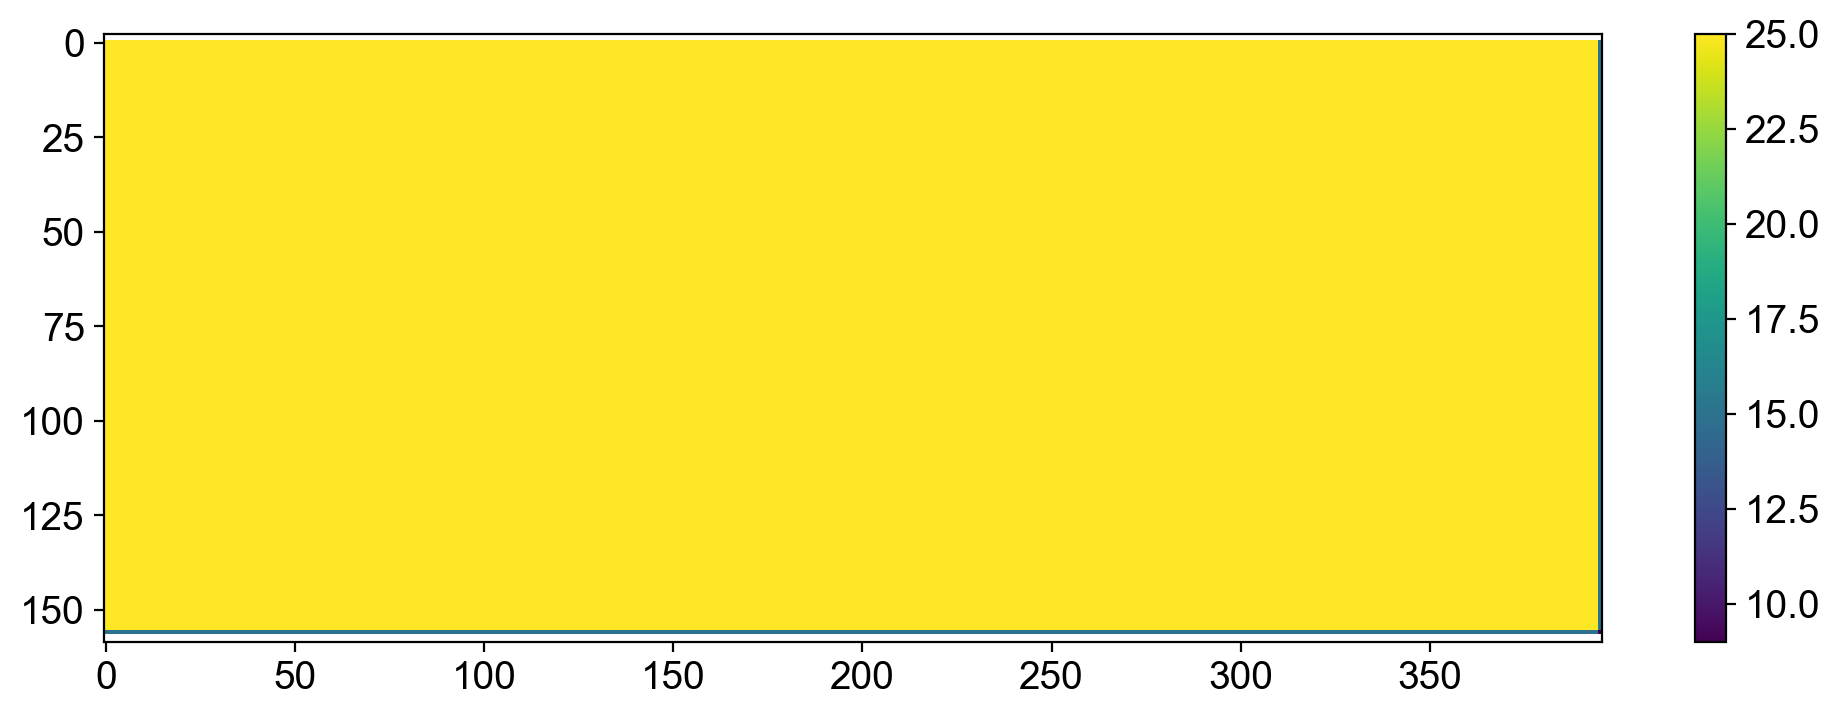

In [33]:
f, ax = plt.subplots(figsize=(12, 4))

beadres = sp.stats.binned_statistic_2d(bead_coords_x, 
                                       bead_coords_y, 
                                       np.ones_like(bead_coords_x),
                                       bins=bins, statistic='sum',
                                       range=ranges)

plt.imshow(beadres.statistic.T)
plt.colorbar();
ax.grid(False)
ax.axis('equal')

In [34]:
beadres.statistic.mean()

24.911117544875506

## Beads per bin (using only beads under tissue)

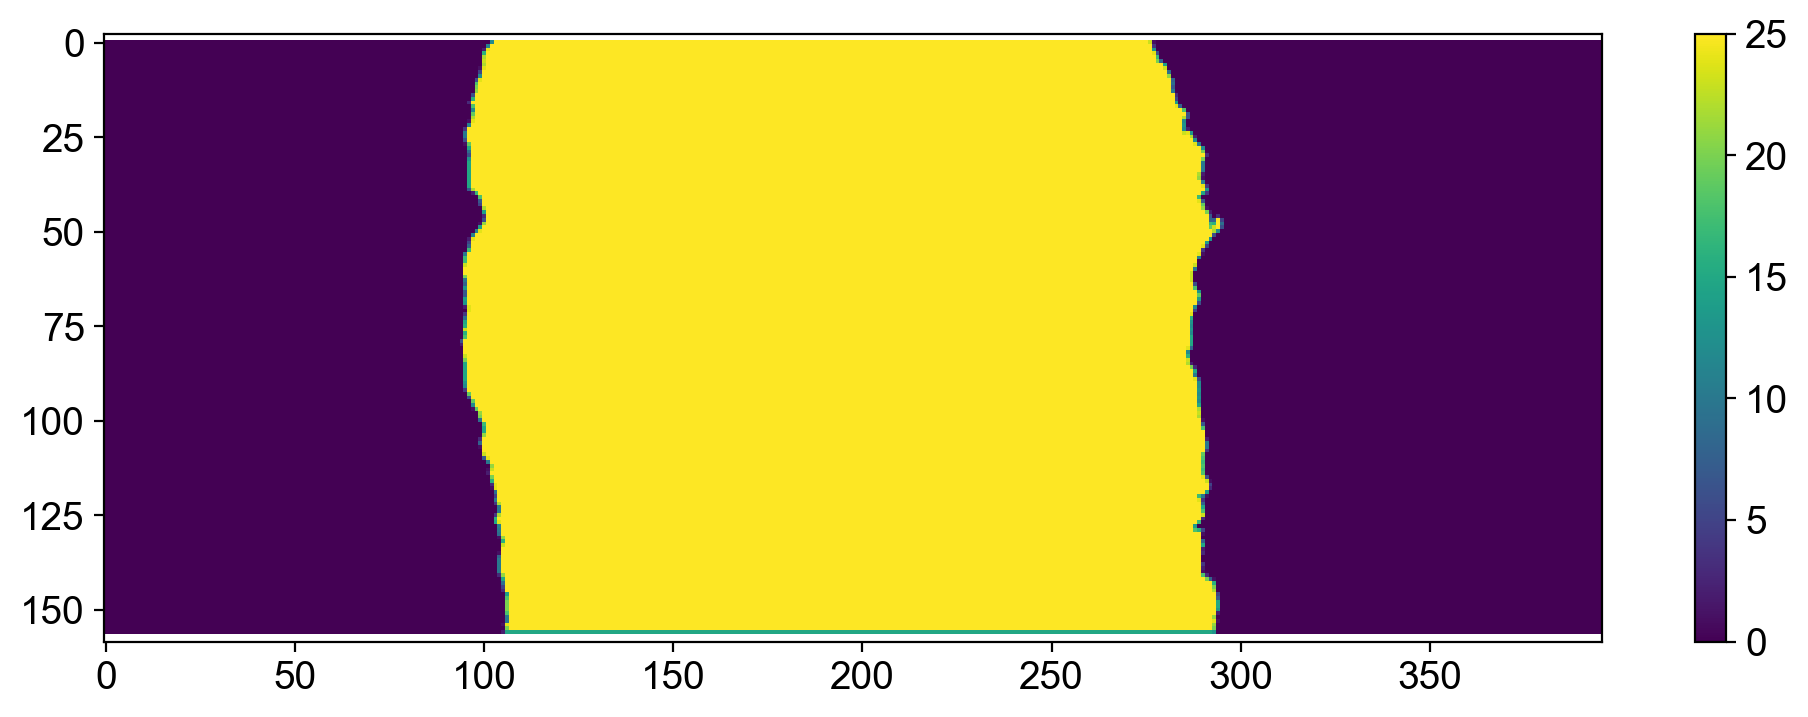

In [35]:
f, ax = plt.subplots(figsize=(12, 4))
beadres = sp.stats.binned_statistic_2d(adata.obs.x, 
                                       adata.obs.y, 
                                       np.ones((len(adata))), 
                                       bins=bins, statistic='sum',
                                       range=ranges,
                                       expand_binnumbers=True)
 
plt.imshow(beadres.statistic.T)
plt.colorbar();
ax.grid(False)
ax.axis('equal');

## Beads per bin (using only beads with expression)

In [36]:
adata

AnnData object with n_obs × n_vars = 742440 × 23058 
    obs: 'region', 'segment', 'x', 'y'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial'

In [37]:
adata.obs.region.value_counts()

Fibrous tissue;Invasive cancer;immune/lymphoid                 154593
Fibrous tissue;Invasive cancer                                 138332
Fatty tissue                                                   121813
Invasive cancer                                                 75503
Fatty tissue;Fibrous tissue;Invasive cancer;immune/lymphoid     51349
Fatty tissue;Invasive cancer;immune/lymphoid                    36813
missing                                                         30232
Fatty tissue;Fibrous tissue;Invasive cancer                     26154
Fibrous tissue                                                  24659
Fatty tissue;Invasive cancer                                    24358
Invasive cancer;immune/lymphoid                                 24028
Fibrous tissue;immune/lymphoid                                  22345
Unknown                                                          7499
Fatty tissue;immune/lymphoid                                     2431
immune/lymphoid     

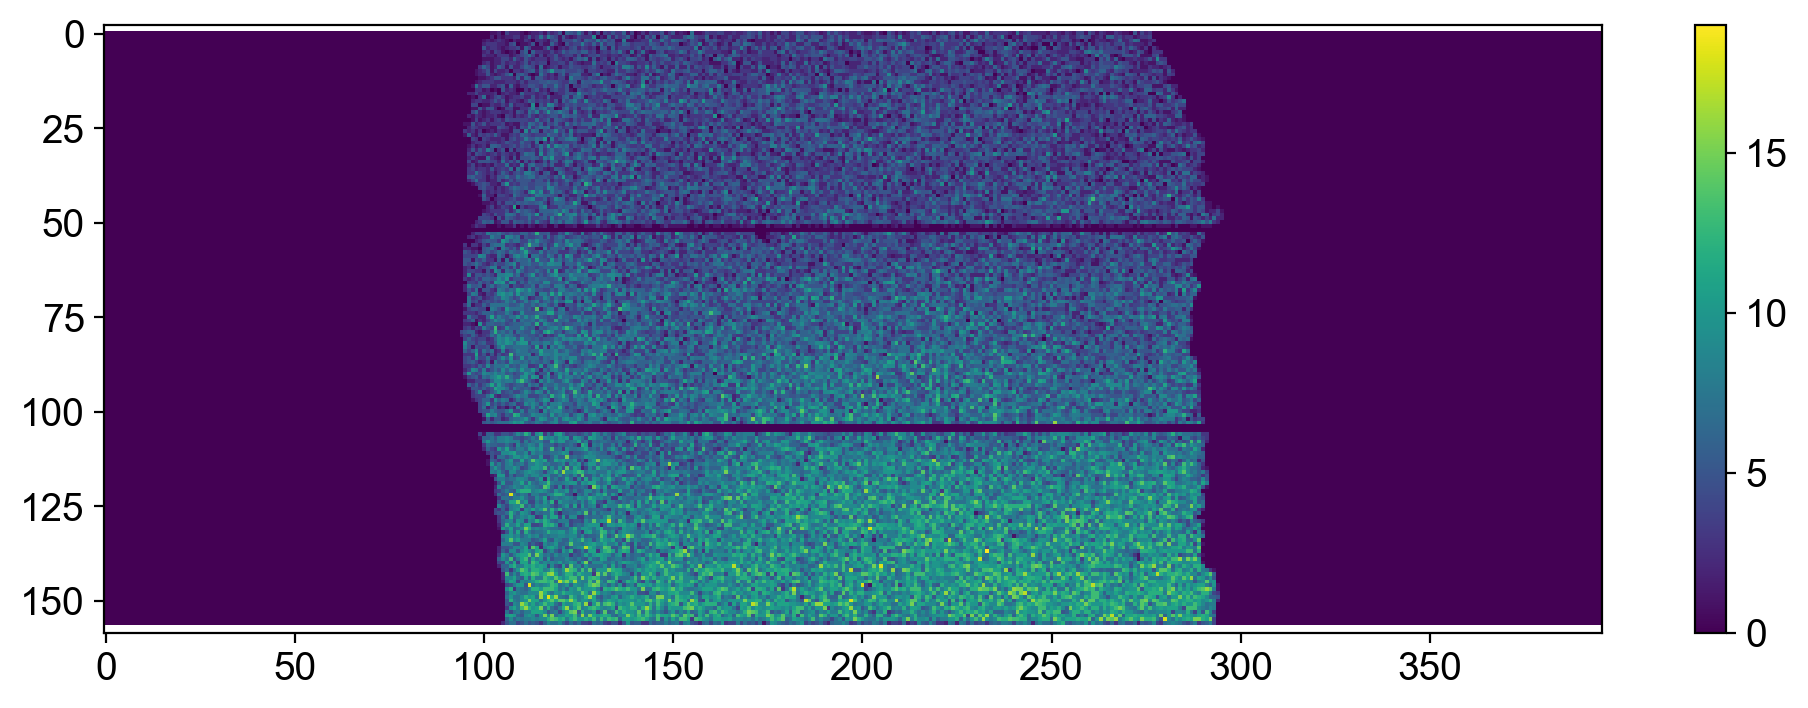

In [38]:
f, ax = plt.subplots(figsize=(12, 4))
ad = sc.pp.filter_cells(adata, min_counts=1, copy=True)
beadres = sp.stats.binned_statistic_2d(ad.obs.x, 
                                       ad.obs.y, 
                                       np.ones((len(ad))), 
                                       bins=bins, statistic='sum',
                                       range=ranges,
                                       expand_binnumbers=True)
 
plt.imshow(beadres.statistic.T)
plt.colorbar();
ax.grid(False)
ax.axis('equal');

In [39]:
beadres.statistic.mean()

2.8618349096056104

## Perform binning

In [40]:
adata_lowres = spatial_bin_adata(adata, 'region', '%sx' % factor, bins, ranges)

In [44]:
adata_lowres

AnnData object with n_obs × n_vars = 62172 × 23058 
    obs: 'x', 'y', 'Fatty tissue', 'Fatty tissue;Fibrous tissue;Invasive cancer', 'Fatty tissue;Fibrous tissue;Invasive cancer;immune/lymphoid', 'Fatty tissue;Invasive cancer', 'Fatty tissue;Invasive cancer;immune/lymphoid', 'Fatty tissue;immune/lymphoid', 'Fibrous tissue', 'Fibrous tissue;Invasive cancer', 'Fibrous tissue;Invasive cancer;immune/lymphoid', 'Fibrous tissue;immune/lymphoid', 'Invasive cancer', 'Invasive cancer;immune/lymphoid', 'Unknown', 'immune/lymphoid', 'missing'
    var: 'gene_symbols', 'gene_ids'

In [45]:
adata_lowres.obsm['X_spatial'] = np.array([adata_lowres.obs.x, adata_lowres.obs.y]).T
adata_lowres.obs['total_counts'] = adata_lowres.X.sum(1)

In [46]:
sc.write('results/hdst-breast-cancer-lowres-%sx.h5ad' % factor, adata_lowres)
sc.write('results/hdst-breast-cancer.h5ad', adata)

... storing 'region' as categorical
... storing 'segment' as categorical


In [47]:
adata = sc.read('results/hdst-breast-cancer.h5ad')
adata_lowres = sc.read('results/hdst-breast-cancer-lowres-%sx.h5ad' % factor)
adata_lowres

AnnData object with n_obs × n_vars = 62172 × 23058 
    obs: 'x', 'y', 'Fatty tissue', 'Fatty tissue;Fibrous tissue;Invasive cancer', 'Fatty tissue;Fibrous tissue;Invasive cancer;immune/lymphoid', 'Fatty tissue;Invasive cancer', 'Fatty tissue;Invasive cancer;immune/lymphoid', 'Fatty tissue;immune/lymphoid', 'Fibrous tissue', 'Fibrous tissue;Invasive cancer', 'Fibrous tissue;Invasive cancer;immune/lymphoid', 'Fibrous tissue;immune/lymphoid', 'Invasive cancer', 'Invasive cancer;immune/lymphoid', 'Unknown', 'immune/lymphoid', 'missing', 'total_counts'
    var: 'gene_symbols', 'gene_ids'
    obsm: 'X_spatial'

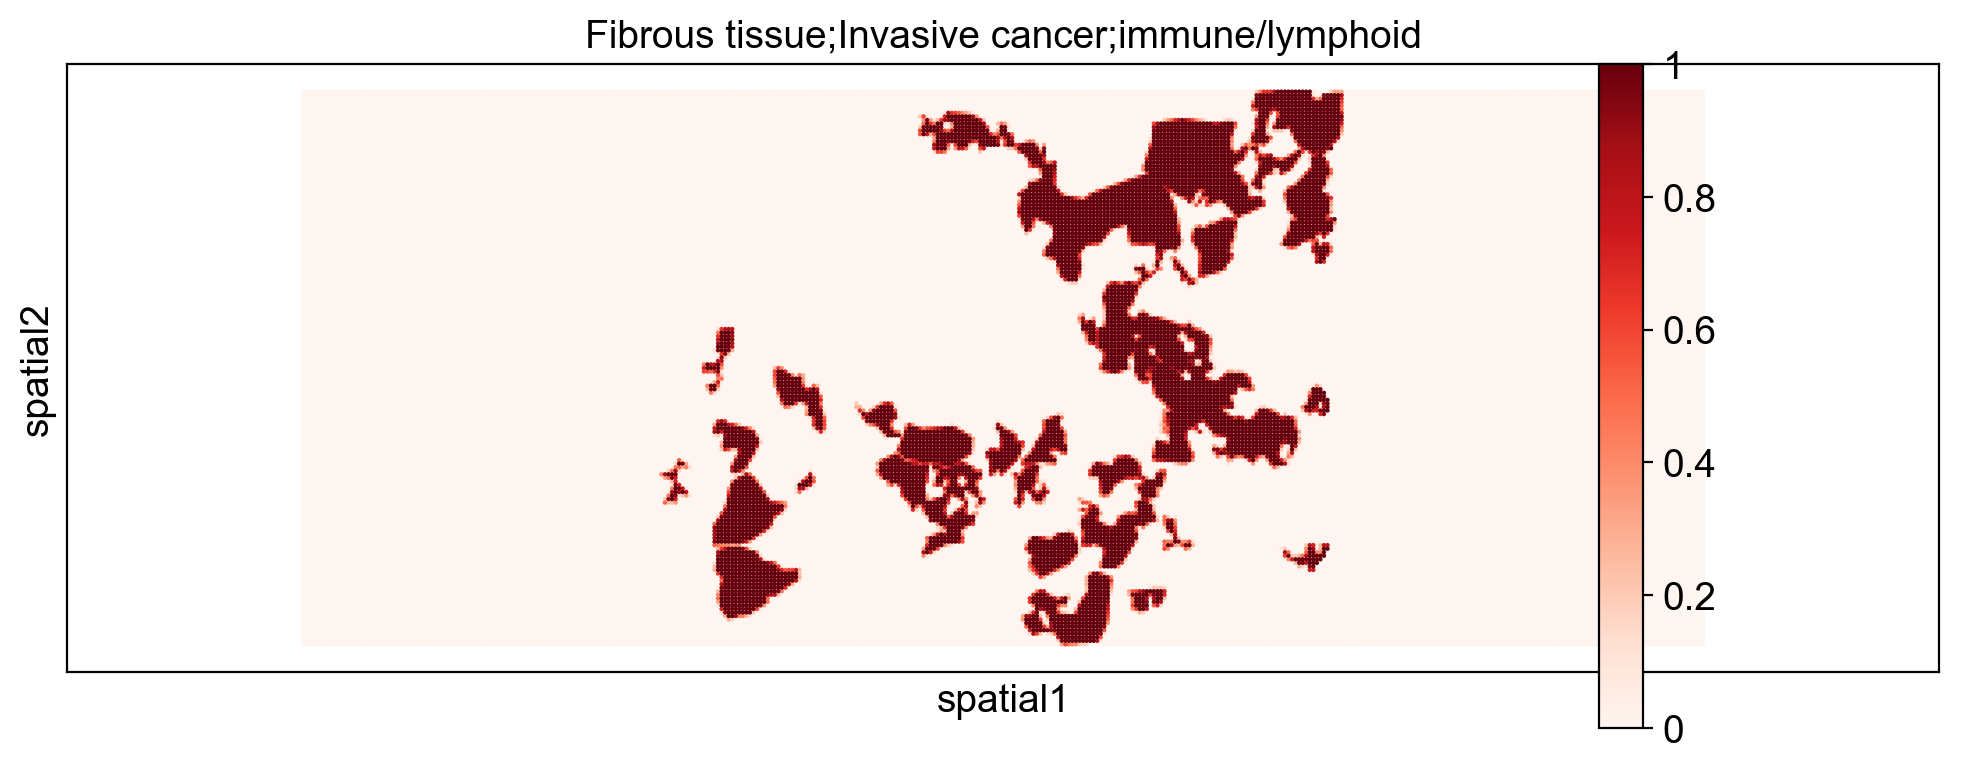

In [48]:
f, ax = plt.subplots(1, 1, figsize=(12, 4))
sc.pl.scatter(adata_lowres, basis='spatial', color='Fibrous tissue;Invasive cancer;immune/lymphoid', size=10, ax=ax, show=False, color_map='Reds')
ax.axis('equal');

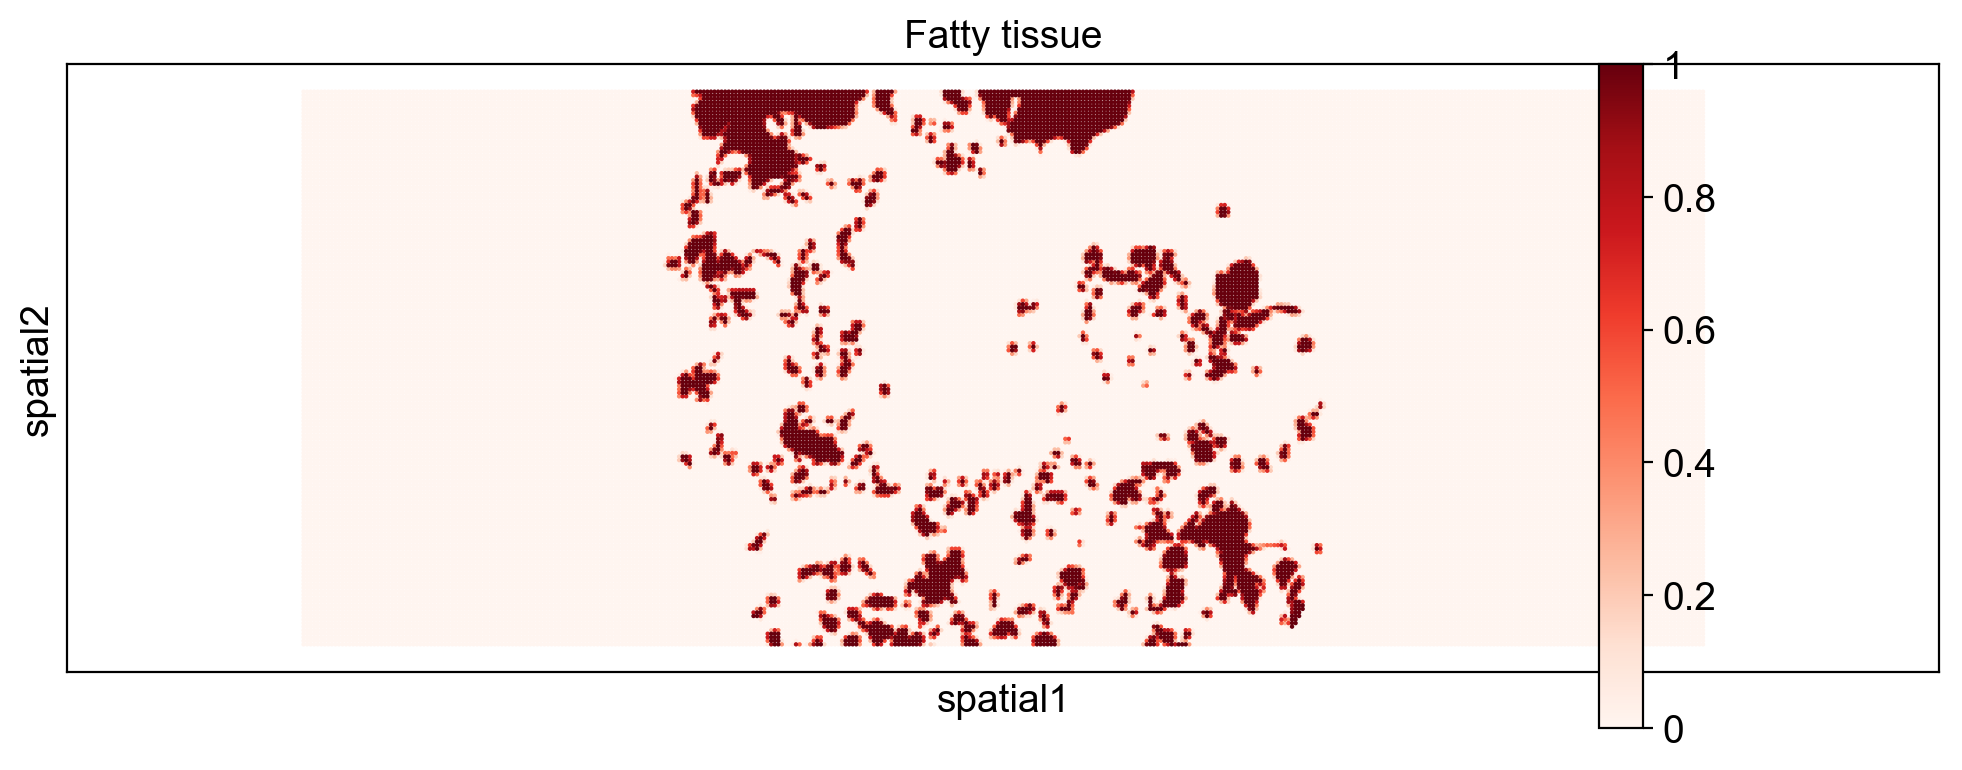

In [49]:
f, ax = plt.subplots(1, 1, figsize=(12, 4))
sc.pl.scatter(adata_lowres, basis='spatial', color='Fatty tissue', size=10, ax=ax, show=False, color_map='Reds')
ax.axis('equal');

### Mean bead per bin

In [50]:
m = beadres.statistic.T
m[m>0].mean(), m[m>0].std()

(6.135590882444222, 3.076026986296187)

## QC after binning

In [29]:
qc = sc.pp.calculate_qc_metrics(sc.pp.filter_cells(adata_lowres, min_counts=1, copy=True))

Text(0, 0.5, 'Number of expressed genes')

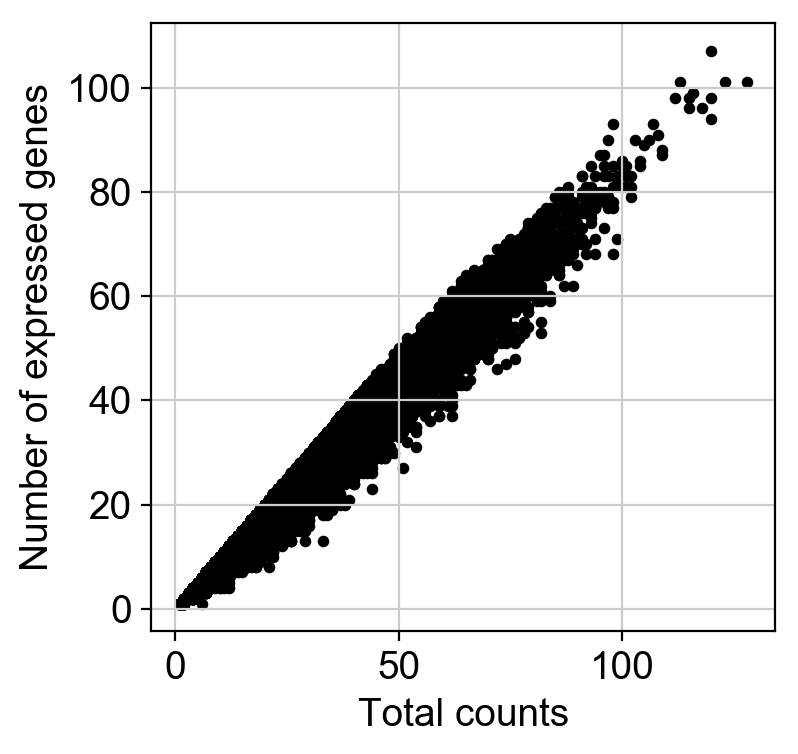

In [30]:
plt.scatter(qc[0].total_counts, qc[0].n_genes_by_counts, c='k', s=10)
plt.xlabel('Total counts')
plt.ylabel('Number of expressed genes')

Text(0.5, 1.0, 'Total counts per gene')

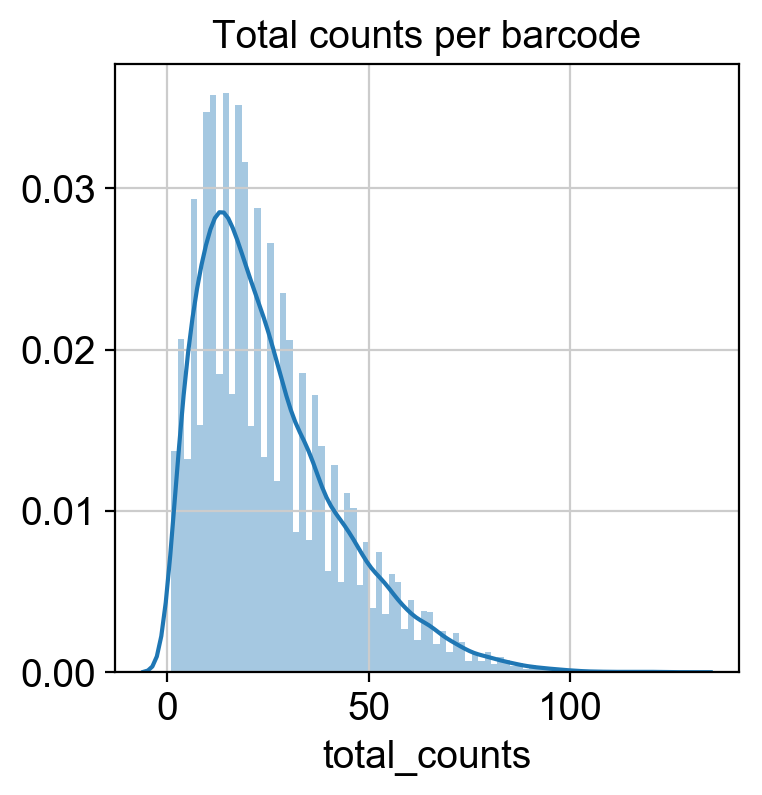

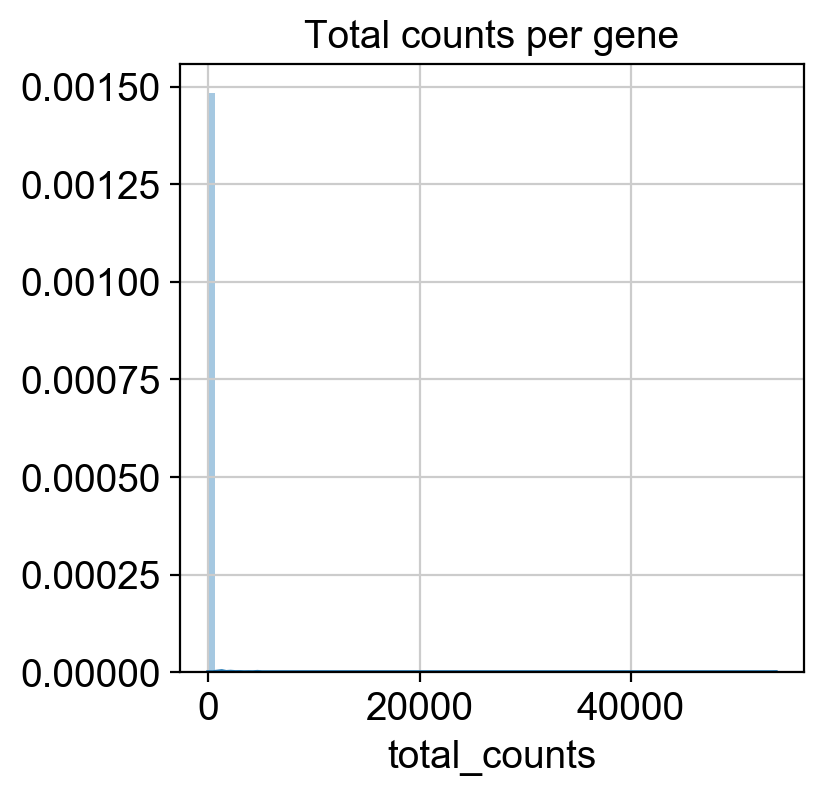

In [31]:
sns.distplot(qc[0].total_counts, bins=80)
plt.title('Total counts per barcode')
plt.figure()
sns.distplot(qc[1].total_counts, bins=80)
plt.title('Total counts per gene')

### Visualize binning

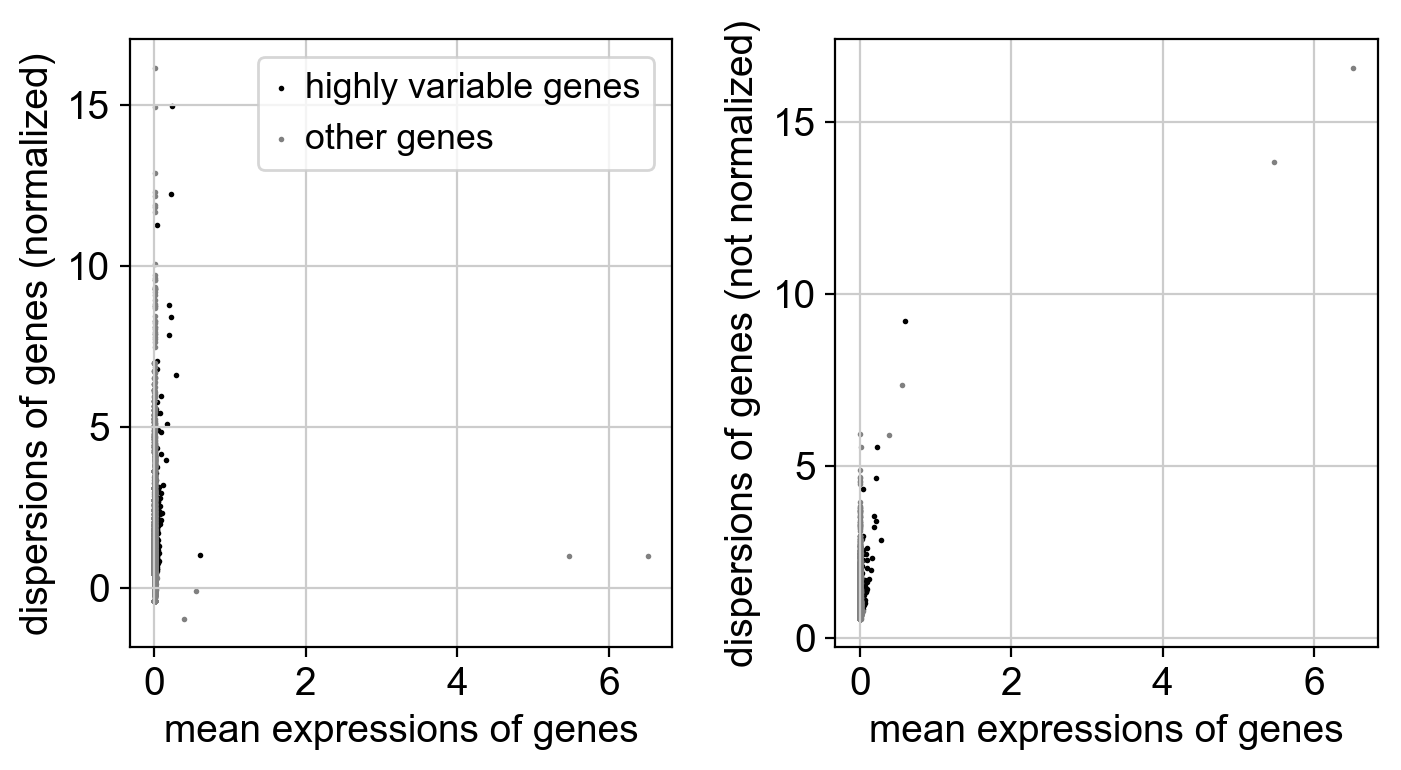

In [32]:
sc.pp.highly_variable_genes(adata_lowres)
sc.pl.highly_variable_genes(adata_lowres)

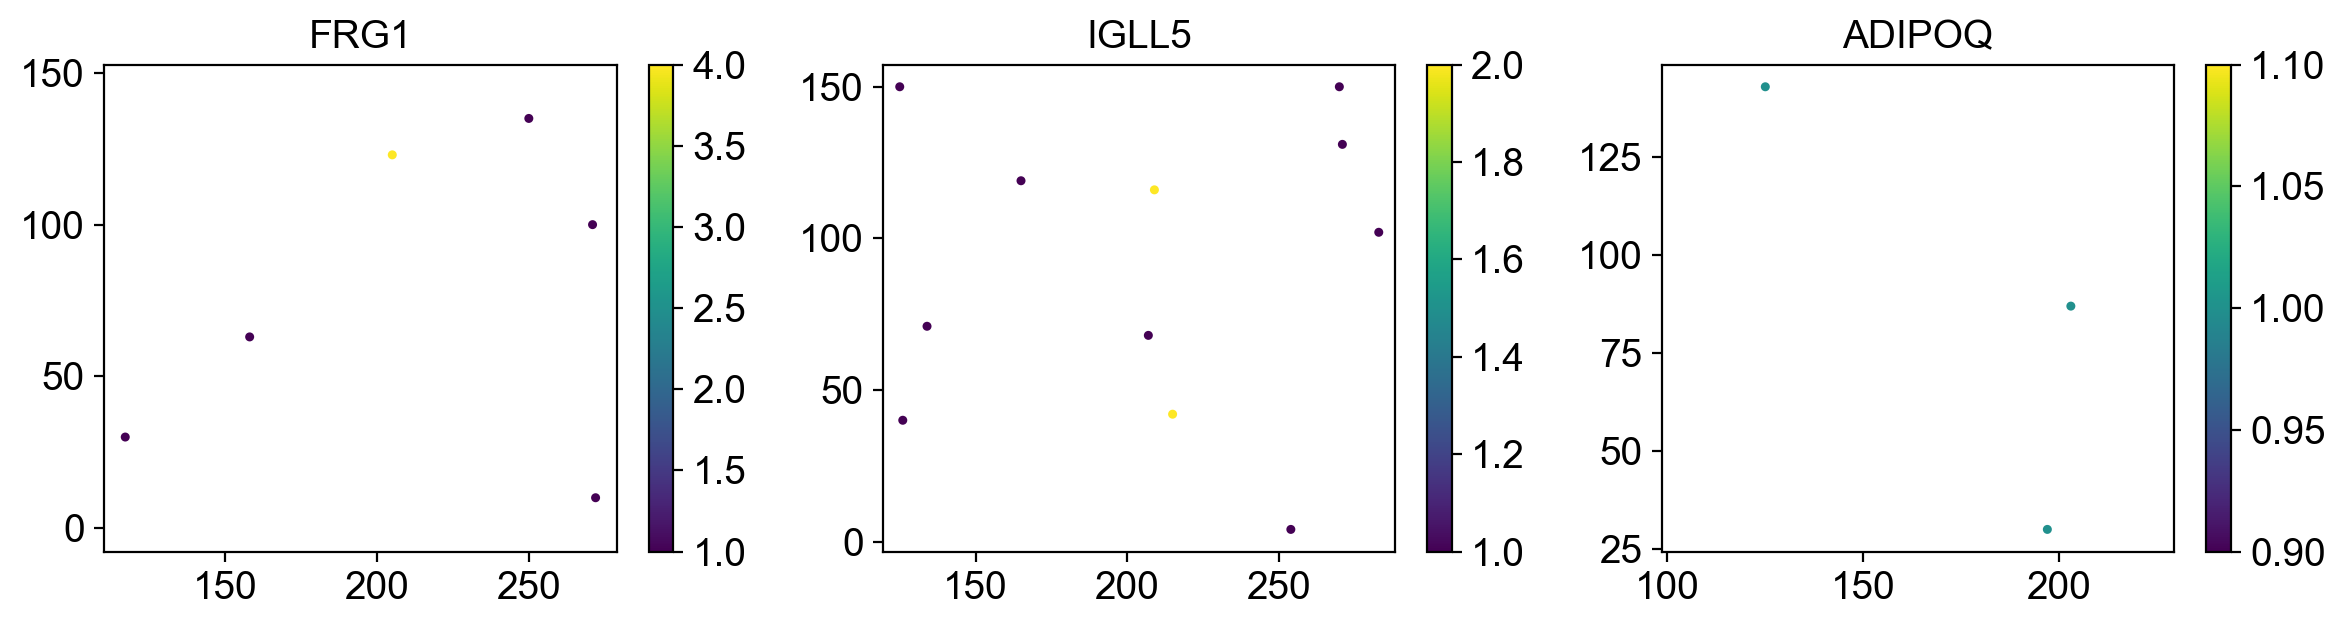

In [38]:
f = plt.figure(figsize=(12, 6))

for i, g in enumerate(['FRG1', 'IGLL5', 'ADIPOQ']):
    ax = plt.subplot(2, 3, i + 1)
    ax.grid(False)

    ad = adata_lowres[:, g]
    ad = ad[ad.X>0]    
    plt.scatter(ad.obs.x, ad.obs.y, c=ad.X, s=5);
    plt.title(g)
    plt.axis('equal')
    plt.colorbar();

plt.tight_layout()

## Save as csv

In [51]:
sc.pp.filter_cells(adata_lowres, min_counts=1, copy=True)

AnnData object with n_obs × n_vars = 28999 × 23058 
    obs: 'x', 'y', 'Fatty tissue', 'Fatty tissue;Fibrous tissue;Invasive cancer', 'Fatty tissue;Fibrous tissue;Invasive cancer;immune/lymphoid', 'Fatty tissue;Invasive cancer', 'Fatty tissue;Invasive cancer;immune/lymphoid', 'Fatty tissue;immune/lymphoid', 'Fibrous tissue', 'Fibrous tissue;Invasive cancer', 'Fibrous tissue;Invasive cancer;immune/lymphoid', 'Fibrous tissue;immune/lymphoid', 'Invasive cancer', 'Invasive cancer;immune/lymphoid', 'Unknown', 'immune/lymphoid', 'missing', 'total_counts', 'n_counts'
    var: 'gene_symbols', 'gene_ids'
    obsm: 'X_spatial'

In [40]:
pd.DataFrame(sc.pp.filter_cells(adata_lowres, 
                                min_counts=1, 
                                copy=True).X, columns=adata.var_names).to_csv('results/hdst-breast-cancer-lowres-%sx.csv.gz' % factor, index=False, compression='gzip')

pd.DataFrame(sc.pp.filter_cells(adata_lowres, 
                                min_counts=1, 
                                copy=True).obs).to_csv('results/hdst-breast-cancer-lowres-%sx-bins.csv.gz' % factor, index=False, compression='gzip')

In [41]:
adata

AnnData object with n_obs × n_vars = 742440 × 23058 
    obs: 'region', 'x', 'y'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial', '5x'

## Generate another resolution level

In [ ]:
factor_mult = 0.

for factor in (38,):

    bins, ranges = calc_bins_and_ranges(factor, bead_coords_x, bead_coords_y)
    print(factor, bins)

    adata_low = spatial_bin_adata(adata, 'region', '%sx' % factor, bins, ranges)
    
    f = plt.figure(figsize=(12, 4))
    
    # Plot some genes
    for i, g in enumerate(['FRG1', 'IGLL5', 'ADIPOQ']):
        ax = plt.subplot(1, 3, i + 1)
        ax.grid(False)

        ad = adata_low[:, g]
        ad = ad[ad.X>0]    
        plt.scatter(ad.obs.x, ad.obs.y, c=ad.X, s=5);
        plt.title(g)
        plt.axis('equal')
        plt.colorbar();

    # save the file as h5ad
    sc.write('results/hdst-breast-cancer-lowres-%dx.h5ad' % factor, adata_low)
    sc.pp.filter_cells(adata_low, min_counts=1)
    
    # save files as CSV
    pd.DataFrame(adata_low.X, columns=adata_low.var_names).to_csv('results/hdst-breast-cancer-lowres-%dx.csv.gz' % factor, index=False, compression='gzip')
    pd.DataFrame(adata_low.obs, index=None).to_csv('results/hdst-breast-cancer-lowres-%dx-bins.csv.gz' % factor, index=False, compression='gzip')

38 (53, 21)


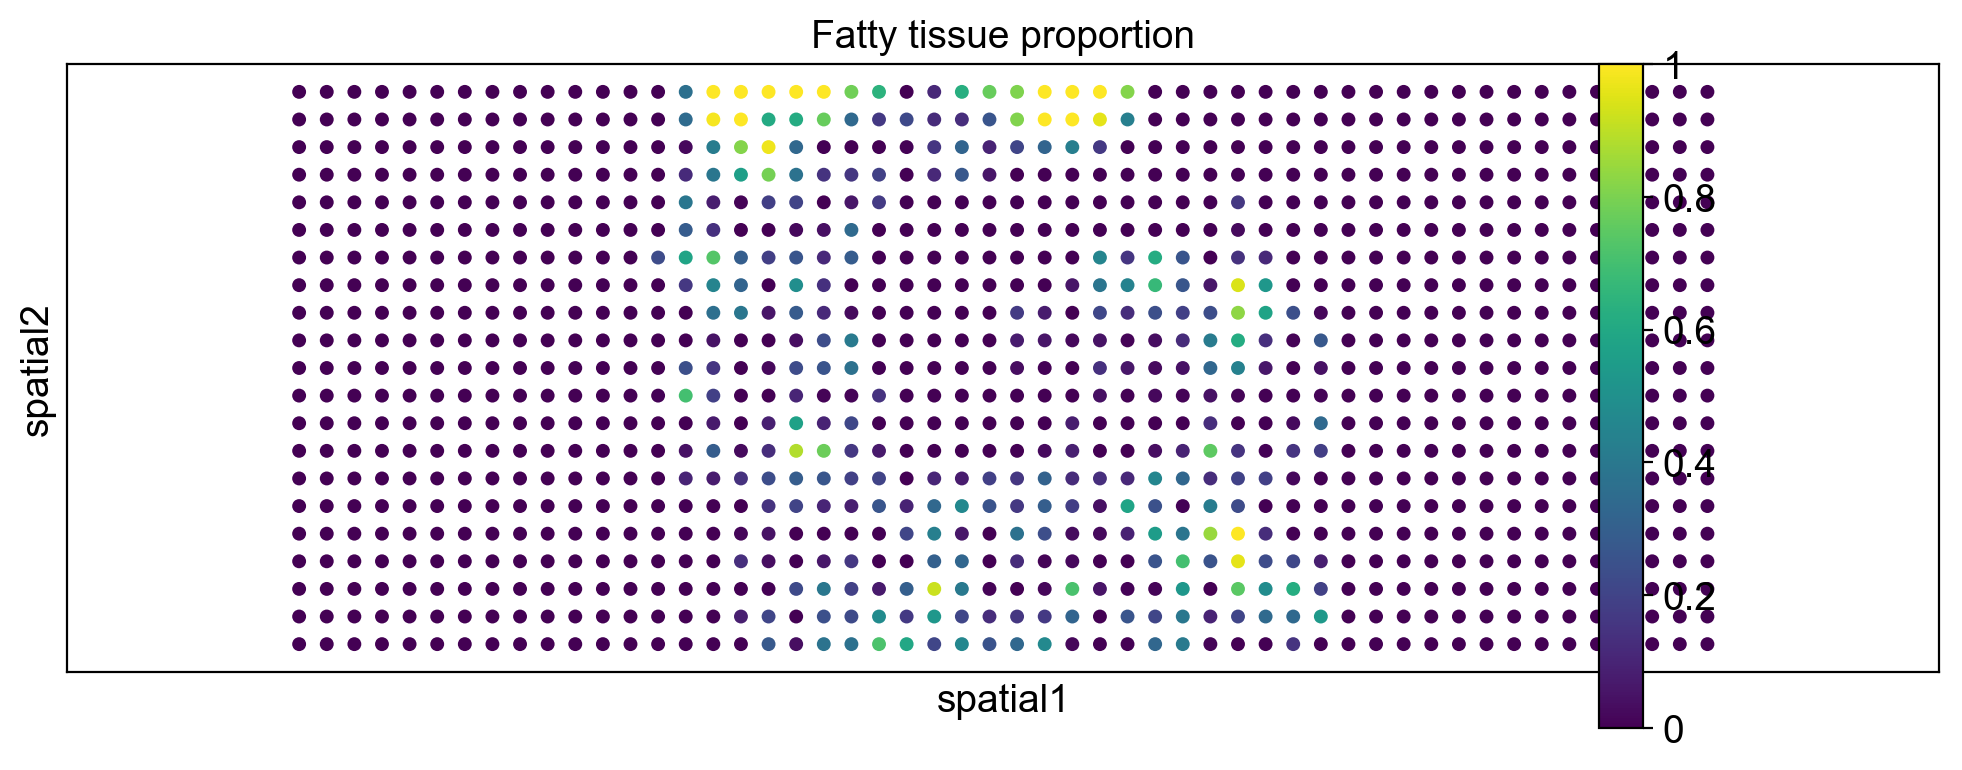

In [43]:
ad_low = sc.read('results/hdst-breast-cancer-lowres-38x.h5ad')
ad_low.obsm['X_spatial'] = np.array([ad_low.obs.x, ad_low.obs.y]).T

f, ax = plt.subplots(1, 1, figsize=(12, 4))
sc.pl.scatter(ad_low, basis='spatial', color='Fatty tissue', size=100, ax=ax, show=False, title='Fatty tissue proportion')
ax.axis('equal');

In [44]:
adata

AnnData object with n_obs × n_vars = 742440 × 23058 
    obs: 'region', 'x', 'y'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial', '5x', '38x'

In [45]:
adata.write('results/hdst-breast-cancer.h5ad')

... storing 'region' as categorical


## Save coordinate mappings

In [46]:
dfs = []
for factor in (5, 38):
    dfs.append(pd.DataFrame(adata.obsm['%sx' % factor], columns=['%sx_x' % factor, '%sx_y' % factor]))
    
coord_df = pd.concat(dfs, axis=1)
coord_df.head()

,5x_x,5x_y,38x_x,38x_y
0,201,1,27,1
1,201,1,27,1
2,201,3,27,1
3,201,21,27,3
4,201,21,27,3


In [47]:
coord_df = pd.concat([adata.obs.reset_index(drop=True), coord_df], axis=1)
coord_df.rename(columns={'x': 'orig_x', 'y': 'orig_y'}, inplace=True)
#coord_df.drop('n_counts', axis=1, inplace=True)
coord_df.head()

,region,orig_x,orig_y,5x_x,5x_y,38x_x,38x_y
0,Fibrous tissue;Invasive cancer,1000,0,201,1,27,1
1,Fibrous tissue;Invasive cancer,1000,1,201,1,27,1
2,Fibrous tissue;Invasive cancer,1000,10,201,3,27,1
3,Fibrous tissue;Invasive cancer,1000,100,201,21,27,3
4,Fibrous tissue;Invasive cancer,1000,101,201,21,27,3


In [48]:
coord_df.to_csv('results/hdst-lowres-coordinates.csv', index=False)